In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Tạo 1 template từ ảnh đầu vào để tìm kiếm
def create_template(image, template, resize=0.7, threshold=200, new_color=100):
    
    obj = image[template[0]:template[1], template[2]:template[3]]
    
# Thay đổi kích thước đối tượng
# obj = cv2.resize(obj, None, fx=resize, fy=resize, interpolation=cv2.INTER_AREA)

# Áp dụng threshold
    obj[obj > threshold] = new_color
    
    plt.imshow(obj, cmap='gray')
    plt.show()

    return obj

#Loại bỏ các bounding box trùng lặp hoặc chồng lấn nhau dựa trên ngưỡng chồng lấn (overlap threshold), giữ lại box có độ tin cậy cao nhất.
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Tính phần chồng lấn (IoU) giữa box hiện tại và các box còn lại
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        # Loại bỏ các box có overlap > overlapThresh
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")
# Đếm số lượng vật thể trong ảnh bằng cách so khớp template (template matching) và áp dụng NMS để loại bỏ kết quả trùng lặp.
def counting_object(img_finding, img_finding_rgb, templates, methods, threshold=0.15, overlapThresh=0.2):
    methods_name = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
                    'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle('Count Pair Boot')

    for idx, method in enumerate(methods):
        rectangles = []
        
        for template in templates:
            template_canny = cv2.Canny(template, 100, 200)
            h, w = template.shape[:2]

            img_canny = cv2.Canny(img_finding, 100, 200)

            result = cv2.matchTemplate(img_canny, template_canny, method)
            
            loc = np.where(result >= threshold)
            
            for pt in zip(*loc[::-1]):
                bottom_right = (pt[0] + w, pt[1] + h)
                rectangles.append([pt[0], pt[1], bottom_right[0], bottom_right[1]])

        rectangles = np.array(rectangles)
        
        if len(rectangles) > 0:
            nms_rectangles = non_max_suppression(rectangles, overlapThresh)
        else:
            nms_rectangles = []

        result_img = img_finding_rgb.copy()
        for (x1, y1, x2, y2) in nms_rectangles:
            cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 0, 255), 5)

    ax.imshow(result_img)
    ax.set_title(f'Method: {methods_name[idx]}\nObjects found: {len(nms_rectangles)}')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

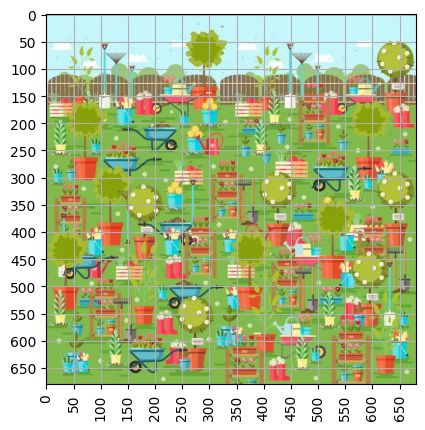

In [59]:
boot_jpg = cv2.imread('pair_boot.jpg')
boot_jpg = cv2.cvtColor(boot_jpg, cv2.COLOR_BGR2RGB)
plt.imshow(boot_jpg)
plt.xticks(range(0, boot_jpg.shape[1], 50), rotation=90)
plt.yticks(range(0, boot_jpg.shape[0], 50))
plt.grid(True)
plt.show()

boot_jpg_rgb = boot_jpg.copy()
boot_jpg = cv2.cvtColor(boot_jpg, cv2.COLOR_RGB2GRAY)

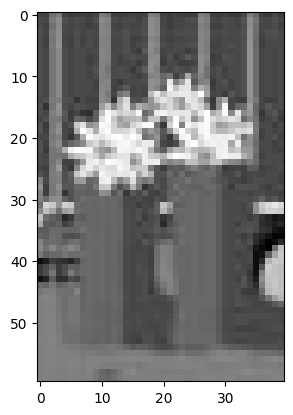

In [60]:
# [y1, y2, x1, x2]
# Lấy chiếc ủng cạnh hàng rào
template = [130, 190, 160, 200]
boot_1 = create_template(boot_jpg, template, 1, 300, 200)

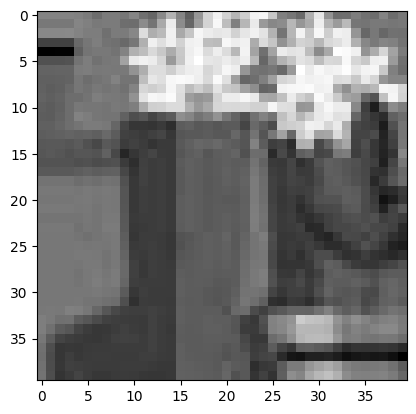

In [61]:
# [y1, y2, x1, x2]
# Lấy chiếc ủng che bởi chậu và bình tưới câycây
template = [520, 560, 540, 580]
boot_2 = create_template(boot_jpg, template, 1, 300, 200)

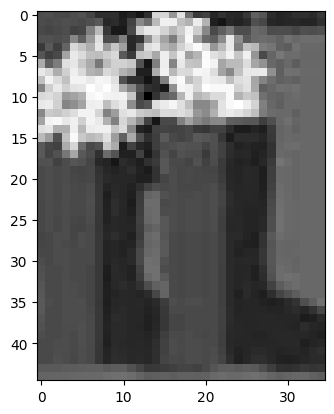

In [62]:
# [y1, y2, x1, x2]
# Lấy chiếc ủng quay trái
template = [165, 210, 640, 675]
boot_3 = create_template(boot_jpg, template, 1, 300, 200)

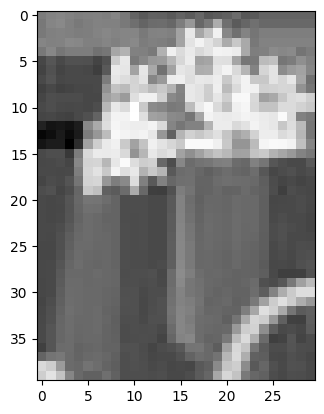

In [63]:
# [y1, y2, x1, x2]
# Lấy chiếc ủng quay trái bị che bởi bình tưới nước
template = [380, 420, 440, 470]
boot_4 = create_template(boot_jpg, template, 1, 300, 200)

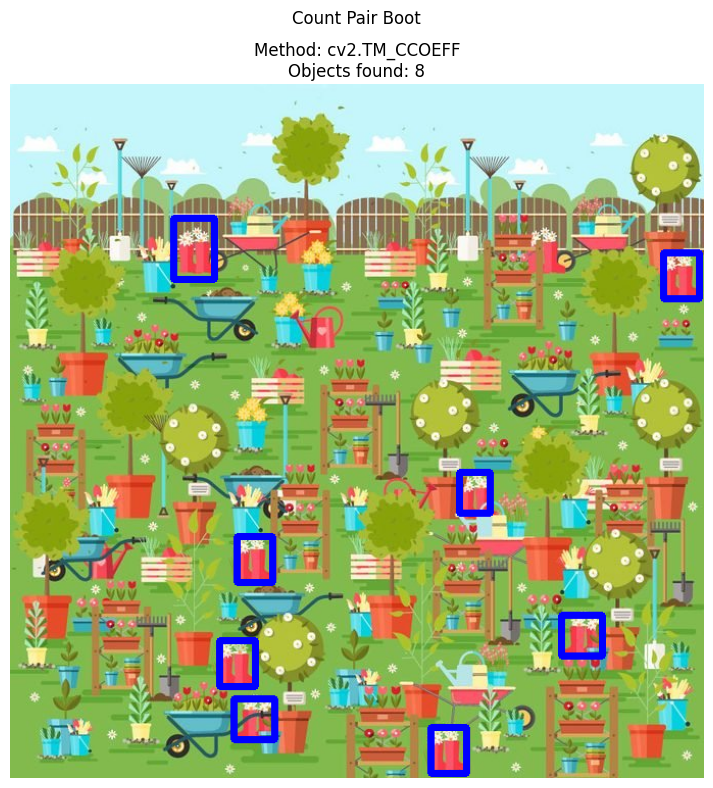

In [64]:
methods = [
    cv2.TM_CCOEFF_NORMED
    ]

templates = [boot_1, boot_2, boot_3, boot_4]

counting_object(img_finding=boot_jpg, img_finding_rgb=boot_jpg_rgb, templates=templates, methods=methods, threshold=0.4, overlapThresh=0.2)
